# Introduction to text embeddings on S&P 500 news

objectives# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Retrieve Financial News:**
   - Use the `yfinance` library to gather news headlines for all companies in the S&P 500 index.

2. **Clean and Structure Financial Text Data:**
   - Extract and organize relevant metadata (e.g., ticker, title, summary, publication date, URL) into a structured pandas DataFrame.

3. **Generate Text Embeddings:**
   - Apply a pre-trained sentence transformer model (`all-MiniLM-L6-v2`) to convert news headlines and summaries into numerical embeddings.

4. **Apply Clustering Techniques:**
   - Use K-Means clustering to identify groups of similar news articles based on semantic content.

5. **Determine Optimal Number of Clusters:**
   - Evaluate clustering quality using silhouette scores to find the best number of clusters.

6. **Visualize High-Dimensional Embeddings:**
   - Reduce the embedding space using PCA and visualize clusters in two dimensions.

7. **Interpret Cluster Themes:**
   - Analyze representative news


## Install and Import important librairies

In [20]:
%pip install pandas
%pip install yfinance
%pip install lxml
%pip install -U sentence-transformers

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.


In [21]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics import silhouette_score
import yfinance as yf



## Get the list of stocks in the S&P 500 

In [22]:
# Read and print the stock tickers that make up S&P500
df_tickers = pd.read_html(
    'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

display(df_tickers.head())

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [23]:
ticker_list = df_tickers['Symbol'].tolist()
ticker_list = [symbol.replace('.', '-') for symbol in ticker_list]

## Get the news of all 500 stocks in the S&P 500 Index
Use the yfinance library to retrieve the news of all 500 stocks in the index.
https://ranaroussi.github.io/yfinance/reference/yfinance.stock.html

### Get the news in a dictionary

In [24]:
# Create a dictionary where the keys are the symbols (tickers) of each 500 stocks 
# and the value is the output news from the yfinance library
import time

news_dict = {}

for ticker in ticker_list:
    try:
        stock = yf.Ticker(ticker)
        news = stock.news
        news_dict[ticker] = news
    except Exception as e:
        print(f"ERROR IN {ticker}: {e}")
        news_dict[ticker] = []  
    time.sleep(0.1) 


In [25]:

for symbol, news_items in list(news_dict.items())[:3]:
    print(f"\nNEWS FROM {symbol}:")
    for item in news_items[:2]: 
        content = item.get('content', {})
        title = content.get('title', 'Sin título')
        summary = content.get('summary', {})
        publisher = content.get('provider', {}).get('displayName', 'Uknown')
        link = content.get('canonicalUrl', {}).get('url', 'Broken')
        print(f" - {title} ({publisher})")
        print(f"   {link}")
        print(f"   {summary}")


NEWS FROM MMM:
 - 3M Company (MMM): “I Was Surprised” By The Organic Growth Rate, Says Jim Cramer (Insider Monkey)
   https://finance.yahoo.com/news/3m-company-mmm-surprised-organic-090300992.html
   We recently published 12 Stocks Jim Cramer Talked About. 3M Company (NYSE:MMM) is one of the stocks Jim Cramer recently discussed. 3M Company (NYSE:MMM) is one of the largest industrial conglomerates in the world. Its shares have gained 16.7% year-to-date as part of a bullish run in industrial stocks that Cramer has commented on several […]
 - Zacks Industry Outlook Highlights Honeywell, 3M, Carlisle Companies and Federal Signal (Zacks)
   https://finance.yahoo.com/news/zacks-industry-outlook-highlights-honeywell-094500804.html
   HON, MMM, CSL, and FSS are well-positioned to benefit from defense, aviation, and infrastructure tailwinds despite manufacturing headwinds.

NEWS FROM AOS:
 - Here's Why A.O. Smith (AOS) is a Strong Value Stock (Zacks)
   https://finance.yahoo.com/news/heres-why

### Structure the news into a pandas dataframe 

Your final dataframe should have the following columns: 
- TICKER
- TITLE (of the news)
- SUMMARY (of the news)
- PUBLICATION_DATE (of the news)
- URL (of the news)

Note: all of those fields are provided in the yfinance news component. Refer to the library documentation.

In [26]:

rows = []

for ticker, news_items in news_dict.items():
    for item in news_items:
        content = item.get("content", {})

        title = content.get("title", "")
        summary = content.get("summary", "")
        pub_date = content.get("pubDate", "")
        url = content.get("canonicalUrl", {}).get("url", "")
        rows.append({"TICKER": ticker,"TITLE": title,"SUMMARY": summary,"PUBLICATION_DATE": pub_date,"URL": url})

df_news = pd.DataFrame(rows)
df_news["PUBLICATION_DATE"] = pd.to_datetime(df_news["PUBLICATION_DATE"], errors="coerce")
print(df_news.head())

  TICKER                                              TITLE  \
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...   
1    MMM  Zacks Industry Outlook Highlights Honeywell, 3...   
2    MMM                 Stock Market News for Jul 21, 2025   
3    MMM  3M Co (MMM) Q2 2025 Earnings Call Highlights: ...   
4    MMM  MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...   

                                             SUMMARY  \
0  We recently published 12 Stocks Jim Cramer Tal...   
1  HON, MMM, CSL, and FSS are well-positioned to ...   
2  U.S. stock markets closed mostly lower n Frida...   
3  3M Co (MMM) reports a 12% increase in adjusted...   
4  Industrial conglomerate 3M (NYSE:MMM) reported...   

           PUBLICATION_DATE                                                URL  
0 2025-07-24 09:03:00+00:00  https://finance.yahoo.com/news/3m-company-mmm-...  
1 2025-07-21 09:45:00+00:00  https://finance.yahoo.com/news/zacks-industry-...  
2 2025-07-21 08:22:00+00:00  https://fina

## Exploring text embeddings

- Use the open-source model: 'sentence-transformers/all-MiniLM-L6-v2' to create embeddings on the news title and summary
- You should combine the title and summary into one string that you will embed together
- Add a column to your news dataframe called EMBEDDED_TEXT using ONLY the TITLE of the news
- Add a column to your news dataframe called EMBEDDINGS, which contains the embedding of EMBEDDED_TEXT


In [27]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')
df_news["EMBEDDED_TEXT"] = df_news["TITLE"].fillna("").astype(str)
embeddings = model.encode(df_news["EMBEDDED_TEXT"].tolist(), show_progress_bar=True)
df_news["EMBEDDINGS"] = embeddings.tolist()
print(df_news[["EMBEDDED_TEXT", "EMBEDDINGS"]].head())

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

                                       EMBEDDED_TEXT  \
0  3M Company (MMM): “I Was Surprised” By The Org...   
1  Zacks Industry Outlook Highlights Honeywell, 3...   
2                 Stock Market News for Jul 21, 2025   
3  3M Co (MMM) Q2 2025 Earnings Call Highlights: ...   
4  MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...   

                                          EMBEDDINGS  
0  [0.006455451250076294, -0.10904763638973236, -...  
1  [-0.021629301831126213, -0.07978319376707077, ...  
2  [-0.037469591945409775, -0.043813712894916534,...  
3  [-0.08080156147480011, -0.02980077639222145, -...  
4  [-0.019502557814121246, -0.07280386984348297, ...  


In [28]:
print(df_news.head()) 

  TICKER                                              TITLE  \
0    MMM  3M Company (MMM): “I Was Surprised” By The Org...   
1    MMM  Zacks Industry Outlook Highlights Honeywell, 3...   
2    MMM                 Stock Market News for Jul 21, 2025   
3    MMM  3M Co (MMM) Q2 2025 Earnings Call Highlights: ...   
4    MMM  MMM Q1 Deep Dive: Tariffs Loom Over Stable Ope...   

                                             SUMMARY  \
0  We recently published 12 Stocks Jim Cramer Tal...   
1  HON, MMM, CSL, and FSS are well-positioned to ...   
2  U.S. stock markets closed mostly lower n Frida...   
3  3M Co (MMM) reports a 12% increase in adjusted...   
4  Industrial conglomerate 3M (NYSE:MMM) reported...   

           PUBLICATION_DATE  \
0 2025-07-24 09:03:00+00:00   
1 2025-07-21 09:45:00+00:00   
2 2025-07-21 08:22:00+00:00   
3 2025-07-19 07:05:47+00:00   
4 2025-07-19 05:30:58+00:00   

                                                 URL  \
0  https://finance.yahoo.com/news/3m-comp

## Using K-means clustering on news embeddings
to simplify, keep only one news for each company (ticker), you should have 500 rows in your news dataframe

In [29]:
# IN THIS PART TO SIMPLIFY WE USE THE FIRST ARTICLE
df_news_unique = df_news.groupby("TICKER", as_index=False).first()
print(f"Total rows after filtering: {len(df_news_unique)}")
print(df_news_unique.tail())

Total rows after filtering: 502
    TICKER                                              TITLE  \
497    XYZ                        1 Reason to Buy Block (XYZ)   
498    YUM  eBay Set to Report Q2 Earnings: What's in Stor...   
499    ZBH  Can ISRG's Strong Q2 Procedure Volume Translat...   
500   ZBRA  Here's What to Expect From Zebra Technologies'...   
501    ZTS  Zoetis (ZTS): Buy, Sell, or Hold Post Q1 Earni...   

                                               SUMMARY  \
497  This innovative financial services enterprise ...   
498  EBAY's Q2 results are likely to reflect gains ...   
499  ISRG's Q2 procedure growth hits 17%, but conti...   
500  Zebra Technologies is all set to release its f...   
501  Over the last six months, Zoetis’s shares have...   

             PUBLICATION_DATE  \
497 2025-07-28 11:20:00+00:00   
498 2025-07-28 15:13:00+00:00   
499 2025-07-25 12:40:00+00:00   
500 2025-07-16 11:57:00+00:00   
501 2025-07-25 04:01:09+00:00   

                             

### Identify the number of clusters using the silhouette score

- Using a for loop, do the clustering with different k values (number of clusters), test 1 to 6 clusters
- Compute the silhouette score for every k value
- Plot the silhouette score for different k values

#### Try different values of k and compute silhouette scores

In [30]:

X = np.vstack(df_news_unique["EMBEDDINGS"].values)
scores = []

for k in range(1, 7):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    if k > 1:
        score = silhouette_score(X, labels)
        scores.append((k, score))
        print(f"k = {k} → Silhouette Score: {score:.4f}")
    else:
        print(f"k = {k} → Silhouette Score: undefined (at least 2 clusters required)")

k = 1 → Silhouette Score: undefined (at least 2 clusters required)
k = 2 → Silhouette Score: 0.0530
k = 3 → Silhouette Score: 0.0557


c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

k = 4 → Silhouette Score: 0.0340
k = 5 → Silhouette Score: 0.0349
k = 6 → Silhouette Score: 0.0398


c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


#### Plot silhouette scores

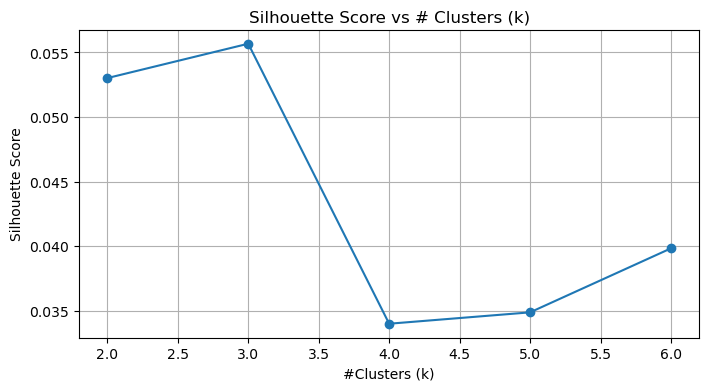

In [31]:
import matplotlib.pyplot as plt

ks, sil_scores = zip(*scores)

plt.figure(figsize=(8, 4))
plt.plot(ks, sil_scores, marker='o')
plt.title("Silhouette Score vs # Clusters (k)")
plt.xlabel("#Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

#### Identify the Best k

c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

k = 2 → Silhouette Score: 0.0530
k = 3 → Silhouette Score: 0.0557
k = 4 → Silhouette Score: 0.0340
k = 5 → Silhouette Score: 0.0349


c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 6 → Silhouette Score: 0.0398

 Best k value: 3 (Silhouette Score: 0.0557)


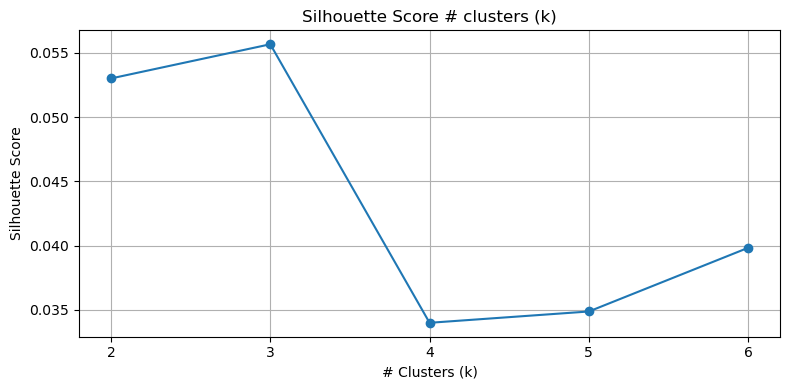

In [32]:
import numpy as np

X = np.vstack(df_news_unique["EMBEDDINGS"].values)

#EVAL 2 - 6
scores = []

for k in range(2, 7):  
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    scores.append((k, score))
    print(f"k = {k} → Silhouette Score: {score:.4f}")

best_k, best_score = max(scores, key=lambda x: x[1])
print(f"\n Best k value: {best_k} (Silhouette Score: {best_score:.4f})")

# Paso 4 (opcional): Graficar el Silhouette Score por cada k
ks, score_values = zip(*scores)
plt.figure(figsize=(8, 4))
plt.plot(ks, score_values, marker='o')
plt.title("Silhouette Score # clusters (k)")
plt.xlabel("# Clusters (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.xticks(ks)
plt.tight_layout()
plt.show()

#### Cluster the embeddings using 3 clusters (k=3)

In [33]:
from sklearn.cluster import KMeans
import numpy as np

X = np.vstack(df_news_unique["EMBEDDINGS"].values)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X)
df_news_unique["CLUSTER"] = cluster_labels
print(df_news_unique[["TICKER", "TITLE", "CLUSTER"]].head())

  TICKER                                              TITLE  CLUSTER
0      A  Agilent Technologies' Q3 2025 Earnings: What t...        1
1   AAPL  Stock market today: Dow, S&P 500, Nasdaq futur...        0
2   ABBV  HS market forecast to reach $7.8bn across 7MM ...        2
3   ABNB  ‘I Prep for Survival’: OpenAI CEO Sam Altman W...        2
4    ABT  Revvity trims 2025 profit forecast as China po...        2


c:\Users\esteb\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [34]:
print(df_news_unique.head())


  TICKER                                              TITLE  \
0      A  Agilent Technologies' Q3 2025 Earnings: What t...   
1   AAPL  Stock market today: Dow, S&P 500, Nasdaq futur...   
2   ABBV  HS market forecast to reach $7.8bn across 7MM ...   
3   ABNB  ‘I Prep for Survival’: OpenAI CEO Sam Altman W...   
4    ABT  Revvity trims 2025 profit forecast as China po...   

                                             SUMMARY  \
0  Agilent Technologies is expected to release it...   
1  US stock futures traded flat as Wall Street pr...   
2  This 15.6% CAGR is largely attributed to the l...   
3  Sam Altman’s reflections on global risk unders...   
4  (Reuters) -Revvity on Monday lowered its full-...   

           PUBLICATION_DATE  \
0 2025-07-24 12:27:49+00:00   
1 2025-07-28 23:37:20+00:00   
2 2025-07-28 17:09:44+00:00   
3 2025-07-28 13:53:13+00:00   
4 2025-07-28 12:09:43+00:00   

                                                 URL  \
0  https://www.barchart.com/story/news/33

### Visualize the 2 first PCA Components of your embeddings

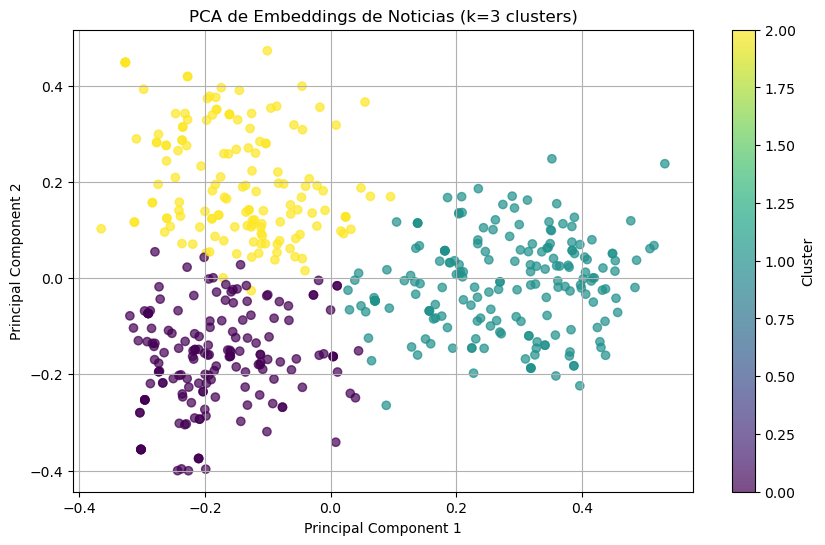

In [35]:

X = np.vstack(df_news_unique["EMBEDDINGS"].values)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_news_unique["PCA1"] = X_pca[:, 0]
df_news_unique["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_news_unique["PCA1"],df_news_unique["PCA2"],c=df_news_unique["CLUSTER"],cmap="viridis",alpha=0.7)
plt.title("PCA de Embeddings de Noticias (k=3 clusters)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()

#### Analyze the content of each cluster
- Add the kmeans cluster label to your news dataframe
- Print the content of each cluster and analyze it

In [38]:

for cluster in sorted(df_news_unique["CLUSTER"].unique()):
    print(f"\n CLUSTER {cluster} — {len(df_news_unique[df_news_unique['CLUSTER'] == cluster])} news")
    muestras = df_news_unique[df_news_unique["CLUSTER"] == cluster].sample(n=3, random_state=42)
    for idx, row in muestras.iterrows():
        print(f"• {row['TICKER']}: {row['TITLE']}")


 CLUSTER 0 — 166 news
• MPC: Should You Be Excited About Marathon Petroleum Corporation's (NYSE:MPC) 18% Return On Equity?
• RMD: 10x Genomics Stock Earns RS Rating Upgrade
• INTU: Intuit (INTU) Exceeds Market Returns: Some Facts to Consider

 CLUSTER 1 — 188 news
• XYL: Countdown to Xylem (XYL) Q2 Earnings: A Look at Estimates Beyond Revenue and EPS
• UPS: Federal Reserve meeting, July jobs report, and Big Tech earnings: What to watch this week
• BALL: Packaging Corp Earnings Surpass Estimates in Q2, Sales Rise Y/Y

 CLUSTER 2 — 148 news
• T: Warner Bros. Cable Arm to Be Named Discovery Global After Split
• ETR: Entergy CEO Highlights Company’s Role in Boosting Economic Growth in the Gulf South
• UNP: UP-Norfolk Southern Merger Would Control Nearly Half of US Rail Container Traffic


In [39]:
from collections import Counter
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text
    
for cluster in sorted(df_news_unique["CLUSTER"].unique()):
    textos = df_news_unique[df_news_unique["CLUSTER"] == cluster]["TITLE"].dropna().tolist()
    textos_limpios = [clean_text(t) for t in textos]
    palabras = " ".join(textos_limpios).split()
    top_palabras = Counter(palabras).most_common(10)

    print(f"\nMost common words per CLUSTER {cluster}:")
    for palabra, count in top_palabras:
        print(f"• {palabra}: {count}")


Most common words per CLUSTER 0:
• stock: 99
• to: 46
• the: 40
• a: 39
• market: 37
• stocks: 35
• is: 29
• on: 26
• and: 25
• of: 20

Most common words per CLUSTER 1:
• earnings: 178
• to: 136
• q: 113
• what: 81
• report: 57
• expect: 43
• the: 35
• in: 34
• estimates: 34
• for: 30

Most common words per CLUSTER 2:
• to: 37
• on: 27
• the: 22
• a: 21
• for: 15
• as: 14
• in: 14
• of: 13
• and: 11
• buy: 11




## Question Section

Take time to reflect on what you've implemented and observed. Answer the following questions in a separate markdown cell or notebook file:

---

### Technical Understanding

#### 1️⃣ How might the choice of embedding model (e.g., MiniLM vs. a larger transformer) affect your clustering results and interpretation?

YOUR WRITTEN RESPONSE HERE

--- The is an actual difference between small-mini models and a large transformer, every model has its strengths and weaknesses, the larger transformes could capture little nuances in the interpretation of certain words or expressions, also tend to be more coherent and have a better syntaxis, howerver this come at great computational cost, they requiere a lot of memory and hardware resources, also they take motre time to embedding the texts, with this in mind, the model selection afects the clustering results and the interpretations, also its essential to balance the computational cost, the embedding time and the contextual accuracy

#### 2️⃣ What would be the differences in embeddings if you used only the TITLE, only the SUMMARY, or the combination of both? How could you empirically test this?

YOUR WRITTEN RESPONSE HERE

--- There is an actual diference, the title has very few words, the summary however adds the context of the story, the combination of both could be a little tricky, because in my opinion the title has the most important facts, the summary however could dilute the most meaningful words, a way to empirically test this, is taking one example of the news previously obtained, the example shown is for the ticker "MMM"

title -- Zacks Industry Outlook Highlights Honeywell, 3M, Carlisle Companies and Federal Signal (Zacks)

summary -- U.S. stock markets closed mostly lower n Friday following trade and tariff related concerns.



#### 3️⃣ In what situations would using a different dimensionality reduction method (e.g., t-SNE, UMAP) be preferable over PCA for visualization of embeddings?

--- The problem with PCA is that it captures only linear variance, wich may have the tendency to skip complex and non-linnear relationships like those present in sentences, the other methods preserve some structure, wich make the neighbourhood relations more visible, wich is better for get some clusterization with a little context.


---

### Data Analysis and Interpretation

#### 4️⃣ Based on your cluster analysis, identify at least two potential challenges you faced in interpreting the clusters and propose strategies to address them.

--- One potential challenge is to label the cluster, or at least identify the sentiment of the news of a specific cluster, the other one is the fact that the nex titles ofthen are similar, in a way they tend to use words like "earnings", "company", so, even the news retrived are from one ticker or company, the data analazyd didn´t have the context of the new relative to the specific ticker.

--- The strategy for labeling the clusters would be to use a model for sentimient analysis, execute that model in every new and clusterize the information with the labels of the model.

--- Also would be usseful to realize the sentiment analysis with the summary of the new, in order to get the exact context of the new to improve the accuracy of the labeling of the new.


#### 5️⃣ Did you observe any outliers in your 2D visualization? How would you identify and handle these outliers in a production pipeline?

--- In order todeal with the outliers in a production pipeline, previously I would run the pipeline for some time, meybe a month, in order to cuantize the daily precentage of outliers, then I would make two test, one removing the outliers, and other selecting another new for the specifics tickers of the outliers, in order to get a new that the model could clusterize with greater accuracy, then I would compare the results of both methods in order to cuantify the impact and then to establish a way to treat with the outliers, if the removal of the outliers didnt impact too much, it could be way faster and cheaper to remove those news.



#### 6️⃣ If you could assign a 'label' or 'theme' to each cluster you obtained, what would they be? How confident are you in these assignments, and what could you do to validate them systematically?


--- I would assign the label of the cluster, based on the most frequent words, by analyzing those words I cousl asign a semantic label, in a confidence level it depend on the variation of the words, so its probably good idea to implement some regex cleanup before, in order to validate systematically we would analyze each title, or some random human verification.

### Critical Thinking

#### 7️⃣ If news sentiment was incorporated into the analysis, how might this influence the clustering structure and interpretation of the clusters in a financial analysis context?

--- It would define the clusters in three ways, positive negative and neutral, relative to the posibility for the stock or the company to get great financial results, wich would drive the price of the stock higgers, in other words, it copuld be intepreted as a bullish signal, a bear signal or a neutral if the posibility of the sotkjc would be sideways in a lateral movement of the sotkc price.

#### 8️⃣ Discuss the limitations of using k-means clustering for news embeddings. What alternative clustering methods could address these limitations, and under what conditions would you prefer them?


--- It´s true that once the new gets embedded, transformed in a numerical vector, Kmeans would agrup similar news and with relatioovely similar context, the limitation ofd this grouping is that this assumes the clusters are sperichal and of similar sizes, also we get to define the K, wich in contrast group the news in similar way to a semantic groupiong, but wiuthout defining explicity the semantic value, also, in the example I use 3 for the "k value", however once the clustering is complete, i have another problem, I have to analize the way it clusterize the news to label the clusters.

--- An alternative method would be to use a model to make sentiment alaysis of the new, this way, the news would be clusterize in 3 groups, negative, positive and neutral (this three gorups are fos context, in reality the model could be defined to make 2 classes positive/negative, 3 classes positive/neutral/negative, 5 classes in wich would separate the positive and negative )

#### 9️⃣ How could the approach in this notebook be extended to analyze the potential impact of news clusters on stock price movements over time? Sketch a high-level pipeline you would implement to test this.

--- This could be by matching the results of the label of the clusters with some technical information of the stock, in other words, we could make a technical analysis, once we get some recomendations based on the technical analysis we need to math it with the recults of the label of the cluster in wich it appears the new os the selected stock, then we would simulate a system like this for some time in order to get some measurements of confidence for the system.

Technical Analysis - > Bullish recomentations -> Match it with the cluster in witch apopears the news of the selected stock -> Simulate -> Measure -> Retro

#### 10️⃣ Imagine your clustering shows clear groups of news, but your downstream task (e.g., prediction of stock movement) does not improve. What might explain this disconnect between clear clusters and predictive utility?

Discarding the fact that It could be a techinical problem in the previous steps, ths stock prediction isn´t a 
